In [1]:
import pandas as pd
import numpy as np

Učitavanje baze kako bi za prosleđene instance alatu uzeli pravu klasu.

In [2]:
database = pd.read_csv('celaBazaPosleEpiMut.csv', sep=',', header=0)

In [3]:
data = pd.read_csv("rezPolyPhenData.csv", sep='\t')

In [4]:
data

#o_acc                  o_pos  o_aa1  o_aa2  rsid        acc         \
0      JAK1                     443      P      L           ?  P23458       
1      SALL4                    624      T      K           ?  Q9UJQ4       
2      SRC                      163      R      W           ?  P12931       
3      MET                      583      I      M           ?  P08581       
4      BRCA1                    275      G      S  rs8176153   P38398       
...                     ...     ...    ...    ...         ...         ...   
16927  IL7R                      56      T      S           ?  P16871       
16928  AKT1                     306      M      I           ?  P31749       
16929  EP300                   1467      Y      N           ?  Q09472       
16930  ERCC4                    210      E      K           ?  Q92889       
16931  TRAF7                      8      R      H           ?  Q6Q0C0       

          pos  aa1  aa2          prediction   pph2_prob    pph2_FPR  \
0         443    P    L   probably damaging           1     0.00026   
1         624    T    K              benign         0.2       0.125   
2         163    R    W   probably damaging           1     0.00026   
3         583    I    M   possibly damaging       0.945       0.054   
4         275    G    S   probably damaging       0.995      0.0277   
...       ...  ...  ...                 ...         ...         ...   
16927      56    T    S              benign       0.266       0.117   
16928     306    M    I              benign       0.003       0.556   
16929    1467    Y    N   probably damaging           1     0.00026   
16930     210    E    K   possibly damaging       0.796      0.0729   
16931       8    R    H   probably damaging       0.998      0.0112   

         pph2_TPR  
0         0.00018  
1           0.916  
2         0.00018  
3           0.796  
4           0.681  
...           ...  
16927       0.909  
16928       0.981  
16929     0.00018  
16930       0.844  
16931       0.273  

[16932 rows x 13 columns]

In [5]:
class_arr = []
index_arr = []
indexForDrop = []
index_TestDataBase = []
classProb = []
for index, row in data.iterrows():
    class_val = database.loc[((database['Gene name'] == row['#o_acc               '].strip()) & (database['variation'] == row['o_aa1'].strip() + str(row[' o_pos']) + row['o_aa2'].strip())), ['Class']]['Class']
    if row['        prediction'] != '           unknown':
        class_arr.append(class_val.values[0])
        classProb.append(row[' pph2_prob'])
        index_arr.append(index)
        index_TestDataBase.append(class_val.index[0])
    else:
        indexForDrop.append(index)

In [6]:
len(index_arr)

16930

In [7]:
len(class_arr)

16930

In [8]:
data[data['        prediction'] == '           unknown']

#o_acc                  o_pos  o_aa1  o_aa2  rsid        acc         \
1015  ARID1B                    56      G      D           ?  Q8NFD5       
5918  PIM1                      22      A      V           ?  P11309       

         pos  aa1  aa2          prediction   pph2_prob    pph2_FPR    pph2_TPR  
1015      56    G    D             unknown           ?           ?           ?  
5918      22    A    V             unknown           ?           ?           ?

Izbacivanje mutacija sa nepoznatim rezultatom.

In [9]:
data = data.drop(index=indexForDrop)

In [10]:
data.columns

Index(['#o_acc               ', ' o_pos', 'o_aa1', 'o_aa2', 'rsid      ',
       'acc       ', '   pos', 'aa1', 'aa2', '        prediction',
       ' pph2_prob', '  pph2_FPR', '  pph2_TPR'],
      dtype='object')

Formiranje baze sa potrebnim informacijama za dobijanje metrika za ocenu alata.

In [11]:
predProb = data[" pph2_prob"]

In [12]:
set(data['        prediction'])

{'            benign', ' possibly damaging', ' probably damaging'}

In [13]:
df1 = {'class':  class_arr,
        'pred': data['        prediction'],
       'pred_prob': data[" pph2_prob"],
      'index' : index_arr}

df = pd.DataFrame (df1, columns = ['class','pred', 'pred_prob', 'index'])

In [14]:
df

class                pred   pred_prob  index
0        1.0   probably damaging           1      0
1        1.0              benign         0.2      1
2        1.0   probably damaging           1      2
3        1.0   possibly damaging       0.945      3
4        0.0   probably damaging       0.995      4
...      ...                 ...         ...    ...
16927    1.0              benign       0.266  16927
16928    1.0              benign       0.003  16928
16929    1.0   probably damaging           1  16929
16930    1.0   possibly damaging       0.796  16930
16931    1.0   probably damaging       0.998  16931

[16930 rows x 4 columns]

Transformacija string-a u numeriču vrednost klasa.

In [16]:
df['pred'].replace({'            benign': 0.0, ' possibly damaging': 1.0, ' probably damaging' : 1}, inplace=True)

In [17]:
df['pred'] = df['pred'].astype('float')

In [18]:
df

class  pred   pred_prob  index
0        1.0   1.0           1      0
1        1.0   0.0         0.2      1
2        1.0   1.0           1      2
3        1.0   1.0       0.945      3
4        0.0   1.0       0.995      4
...      ...   ...         ...    ...
16927    1.0   0.0       0.266  16927
16928    1.0   0.0       0.003  16928
16929    1.0   1.0           1  16929
16930    1.0   1.0       0.796  16930
16931    1.0   1.0       0.998  16931

[16930 rows x 4 columns]

In [55]:
from sklearn import metrics

Izdvajanje metrika alata.

In [59]:
prob = [1.0 if float(e)>0.5 else 0.0 for e in df['pred_prob']]

In [60]:
metrics.accuracy_score(df['class'], prob)

0.6782634376845835

In [67]:
metrics.balanced_accuracy_score(df['class'], prob)

0.6412355599103081

In [61]:
metrics.precision_score(df['class'], prob)

0.9783412572636028

In [62]:
metrics.recall_score(df['class'], prob)

0.6811745233862564

In [63]:
metrics.roc_auc_score(df['class'], prob)

0.6412355599103081

In [64]:
metrics.f1_score(df['class'], prob)

0.8031513136496693

In [65]:
metrics.confusion_matrix(df['class'], prob)

array([[  371,   246],
       [ 5201, 11112]])

In [23]:
import matplotlib.pyplot as plt  
import seaborn as sns

[Text(0, 0.5, 'neutral'), Text(0, 1.5, 'cancer')]

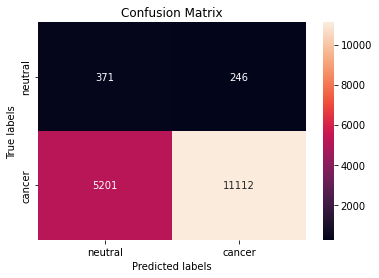

In [66]:
ax = plt.subplot()
sns.heatmap(metrics.confusion_matrix(df['class'], prob), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['neutral', 'cancer'])
ax.yaxis.set_ticklabels(['neutral', 'cancer'])

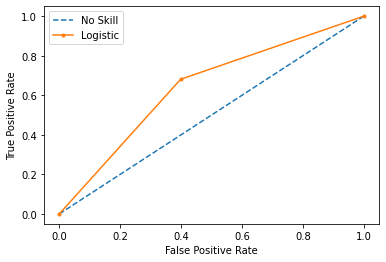

In [77]:
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = metrics.roc_curve(df["class"], prob)
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Izdvajanje mutacije sa pogrešnim predviđanjem.

In [78]:
indexMis = df[df['class'] != df['pred']]['index']

In [79]:
indexMis.values

array([    1,     4,    12, ..., 16925, 16927, 16928])

In [80]:
dataMisclass = data.iloc[indexMis.values]

In [81]:
dataMisclass['#o_acc               '].value_counts()[0:10]

LRP1B                   140
FAT4                    113
APC                      92
NOTCH1                   91
FAT1                     89
ZFHX3                    70
GRIN2A                   66
ERBB4                    62
ATM                      62
POLE                     61
Name: #o_acc               , dtype: int64

In [83]:
databaseTest = pd.read_csv('testDataRF.csv', sep=',', header=0)

Koliko gena je zastupljeno u test skupu koji se prosledio alatu, kako bi se uporedio sa brojem gena u čijim mutacijama je greši prisutna.

In [84]:
databaseTest['Gene name'].value_counts()[0:10]

LRP1B     477
KMT2D     397
FAT4      373
NOTCH1    301
FAT1      279
APC       266
ATM       251
ZFHX3     241
BRCA2     207
ERBB4     202
Name: Gene name, dtype: int64

In [105]:
data['#o_acc               '].value_counts()

LRP1B                   477
FAT4                    373
NOTCH1                  301
FAT1                    279
APC                     266
                       ... 
BTK                       3
HIF1A                     3
ATR                       2
MYD88                     2
FAS                       1
Name: #o_acc               , Length: 251, dtype: int64

I ako je KMT2D gen prisutan u prosleđenom test skupu, alat ga ne prepoznaje.

In [106]:
data[data['#o_acc               '] == "KMT2D"]

Empty DataFrame
Columns: [#o_acc               ,  o_pos, o_aa1, o_aa2, rsid      , acc       ,    pos, aa1, aa2,         prediction,  pph2_prob,   pph2_FPR,   pph2_TPR]
Index: []

Izdvajanje mutacije za koje se javila greška u alatu.

In [86]:
diffMask = np.setdiff1d(databaseTest['Unnamed: 0'], index_TestDataBase, assume_unique=False)

In [87]:
diffMask

array([  822,   826,   952, ..., 93968, 93972, 93981])

In [88]:
dataNotInResponse = database.iloc[diffMask]

In [89]:
dataNotInResponse

Gene name   pos a1 a2 variation  \
822          AR   646  A  D     A646D   
826          AR   794  E  D     E794D   
952        EXT2   467  A  V     A467V   
958        EXT2   158  T  A     T158A   
1245      PTPRC  1285  S  R    S1285R   
...         ...   ... .. ..       ...   
93962     AMER1   938  G  R     G938R   
93965     AMER1  1114  A  V    A1114V   
93968     AMER1   129  S  N     S129N   
93972     AMER1   591  R  M     R591M   
93981     AMER1   834  L  I     L834I   

       alpha-CH chemical shifts (Andersen et al., 1992) 1  \
822                                            10.311254    
826                                           -18.211537    
952                                            12.348329    
958                                             0.000000    
1245                                           -5.141346    
...                                                  ...    
93962                                          12.525720    
93965                                         -10.929670    
93968                                          -6.856993    
93972                                          -2.348392    
93981                                          -1.486341    

       Hydrophobicity index (Argos et al., 1982) 1  \
822                                      23.385986   
826                                       1.165086   
952                                      76.457153   
958                                       6.422752   
1245                                     55.903351   
...                                            ...   
93962                                    69.001613   
93965                                   -67.934679   
93968                                     1.360296   
93972                                    82.136092   
93981                                   -79.787887   

       Signal sequence helical potential (Argos et al., 1982) 1  \
822                                             2.621740          
826                                            -8.687008          
952                                             6.001744          
958                                            -3.285885          
1245                                          -81.308626          
...                                                  ...          
93962                                          41.760818          
93965                                          14.584819          
93968                                         -92.667333          
93972                                         -67.555261          
93981                                        -261.426888          

       Membrane-buried preference parameters (Argos et al., 1982) 1  \
822                                            32.909480              
826                                           -11.363413              
952                                            24.069522              
958                                            -5.700172              
1245                                          -38.738151              
...                                                  ...              
93962                                          24.291007              
93965                                          56.771881              
93968                                         -58.494747              
93972                                        -117.148699              
93981                                        -182.196953              

       Conformational parameter of inner helix (Beghin-Dirkx, 1975) 1  ...  \
822                                             2.673962               ...   
826                                             4.517740               ...   
952                                            -5.770689               ...   
958                                            11.472580               ...   
1245                                            5.989036               ...   
...  

In [90]:
len(dataNotInResponse[dataNotInResponse["Class"] == 1.0])

2199

In [91]:
len(dataNotInResponse[dataNotInResponse["Class"] == 0.0])

51

In [92]:
dataNotInResponse['Gene name'].value_counts()

KMT2D      370
ATR        158
PTPRB      117
ARID1B      96
PTPRT       92
AMER1       91
GNAS        89
ABL1        85
AR          81
PTPRC       78
CACNA1D     74
SMO         60
NCOR2       60
RBM10       53
TGFBR2      50
CUX1        49
BTK         49
MET         47
WT1         46
PIM1        44
PTPN13      40
FGFR3       39
PBRM1       37
FGFR2       35
POLD1       33
MAP2K4      31
EXT2        29
EZH2        26
HIF1A       22
TENT5C      22
CXCR4       20
BRCA1       19
PPP6C       14
FAS         13
CD79B       12
CSF3R       10
GPC3        10
STAG2        9
MYD88        9
KLF4         8
HNF1A        7
RAC1         6
PLCG1        4
BAX          2
DNM2         1
BRIP1        1
TSHR         1
ATRX         1
Name: Gene name, dtype: int64

In [94]:
databaseTest[databaseTest["Gene name"] == "KMT2D"]

Unnamed: 0 Gene name variation  \
5           24507     KMT2D    C5109W   
40          23784     KMT2D    R5030L   
47          23617     KMT2D    L3266P   
72          24732     KMT2D    G4278V   
86          24618     KMT2D    G3319D   
...           ...       ...       ...   
18909       23381     KMT2D     L851Q   
18991       24370     KMT2D    E3068G   
19116       24037     KMT2D     A387D   
19161       23589     KMT2D    A5187T   
19164       23950     KMT2D     E436K   

       alpha-CH chemical shifts (Andersen et al., 1992) 1  \
5                                               2.875034    
40                                            -13.044060    
47                                             16.977271    
72                                             -1.710131    
86                                             51.580009    
...                                                  ...    
18909                                         -21.842341    
18991                                         -16.658173    
19116                                         -51.618421    
19161                                           0.000000    
19164                                          -8.700909    

       Hydrophobicity index (Argos et al., 1982) 1  \
5                                      -498.546930   
40                                     -378.853817   
47                                        3.652019   
72                                      146.406996   
86                                       39.226632   
...                                            ...   
18909                                   724.263936   
18991                                   121.781488   
19116                                    33.664413   
19161                                   112.689626   
19164                                  -201.149604   

       Signal sequence helical potential (Argos et al., 1982) 1  \
5                                             314.844513          
40                                           1386.845678          
47                                           -562.692628          
72                                           -242.615896          
86                                           -101.695924          
...                                                  ...          
18909                                         776.993175          
18991                                          69.331158          
19116                                          40.228620          
19161                                          90.719311          
19164                                         -21.327948          

       Membrane-buried preference parameters (Argos et al., 1982) 1  \
5                                              42.921668              
40                                           1056.034846              
47                                           -413.263826              
72                                           -207.408992              
86                                           -115.345643              
...                                                  ...              
18909                                         751.387456              
18991                                          57.244698              
19116                                           9.227300              
19161                                         176.876169              
19164                                         -31.180503              

       Conformational parameter of inner helix (Beghin-Dirkx, 1975) 1  \
5                                            -108.689925                
40                                            -95.782186                
47                                            205.184281                
72                                             85.958013                
86                                            -19.538406                
...                                 

In [103]:
dataNotInResponse.to_csv("notInPolyPhen2Response.csv", header=True)